# Pre-Precessing scRNA-seq data

## Imports

In [35]:
import matplotlib.pyplot as plt
import scanpy as sc
import scrublet as scr
import harmonypy as harm

## Defining scanpy setting

Here we are setting ***scanpy*** to show us warnings and stetting the size of the pictures it will generate.

In [36]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

results_file = 'preprocessing/preprocessed.h5ad'  # the file that will store the analysis results


## Load and prepare dataset

Here we will create our **AnnData** object, that wil contain our dataset. In this case we will use the **paul15** dataset ([Paul *et al.* 2015](DOI:https://doi.org/10.1016/j.cell.2015.11.013)) which is integatred with **scanpy**. Far that reason we only need to type the following commands in order to obtain the dataset.

In [37]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


In [38]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

### Adding information to the dataset

In [39]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith("Mt")
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL", "rps", "rpl", "Rps", "Rpl"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.startswith("Hb")

## Quality Control

### Calculate QC

In [40]:
#normal qc metrics 
sc.pp.calculate_qc_metrics(adata)

#mt, ribo and hnn metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [41]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
0610007L01Rik,False,False,False,935,0.490842,65.750916,1340.0
0610009O20Rik,False,False,False,598,0.283516,78.095238,774.0
0610010K14Rik,False,False,False,1842,1.513553,32.527473,4132.0
0910001L09Rik,False,False,False,1092,0.621978,60.000000,1698.0
1100001G20Rik,False,False,False,115,0.067766,95.787546,185.0
...,...,...,...,...,...,...,...
mKIAA1027,False,False,False,2281,2.776191,16.446886,7579.0
mKIAA1575,False,False,False,564,0.265568,79.340659,725.0
mKIAA1994,False,False,False,676,0.399267,75.238095,1090.0
rp9,False,False,False,1805,1.839927,33.882784,5023.0


In [42]:
adata.obs

,paul15_clusters,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
0,7MEP,277,353.0,0.0,0.000000,27.0,7.648725,0.0,0.000000
1,15Mo,1021,2556.0,9.0,0.352113,138.0,5.399061,0.0,0.000000
2,3Ery,1466,4649.0,43.0,0.924930,247.0,5.312971,1.0,0.021510
3,15Mo,1415,4486.0,11.0,0.245207,149.0,3.321445,0.0,0.000000
4,3Ery,1505,5205.0,45.0,0.864553,290.0,5.571566,4.0,0.076849
...,...,...,...,...,...,...,...,...,...
2725,2Ery,1401,4873.0,62.0,1.272317,284.0,5.828032,0.0,0.000000
2726,13Baso,1209,3553.0,6.0,0.168871,217.0,6.107515,0.0,0.000000
2727,7MEP,322,443.0,0.0,0.000000,40.0,9.029346,0.0,0.000000
2728,15Mo,1196,3252.0,9.0,0.276753,152.0,4.674047,0.0,0.000000


### Plot QC

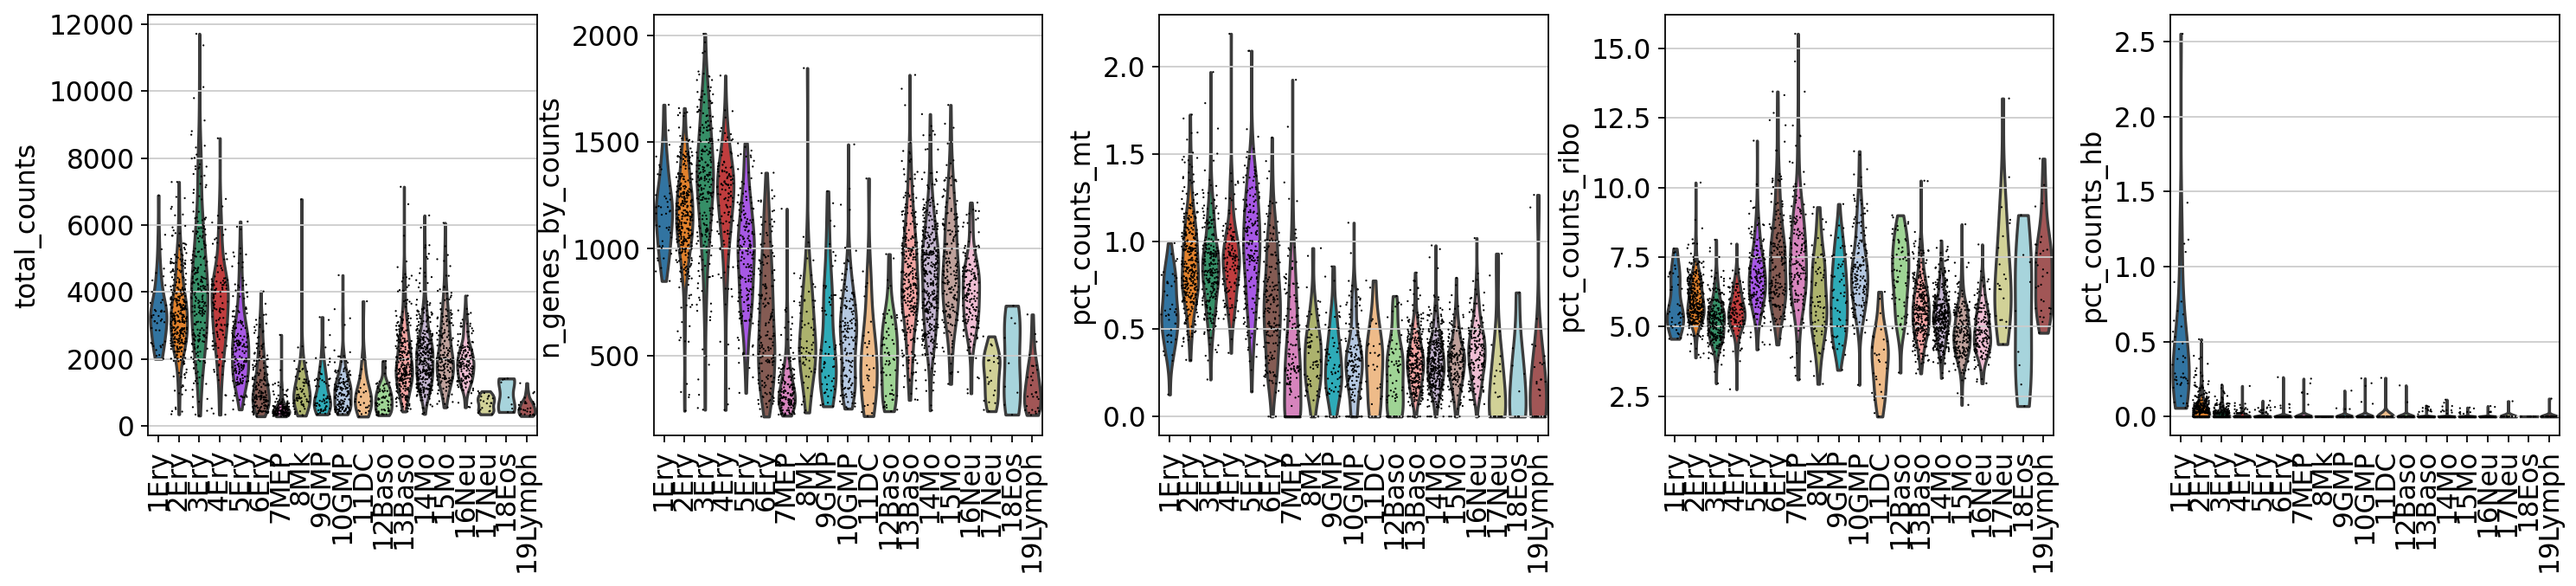

In [43]:
sc.pl.violin(adata, ["total_counts", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"], jitter=0.4, ncols=2, groupby='paul15_clusters', rotation=90)

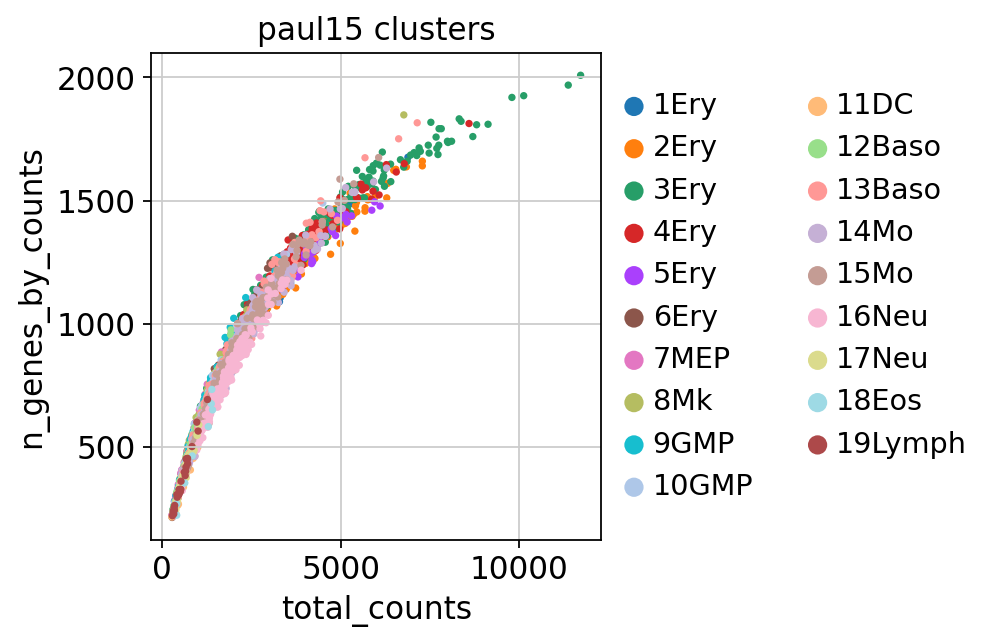

In [44]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="paul15_clusters")

## Normalization

In [45]:
# normalize to depth 10 000 (CPM)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# store normalized counts in the raw slot,
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'iroot', 'paul15_clusters_colors', 'log1p'

## Filtering

### Filtering genes and cells


filtered out 134 cells that have less than 300 genes expressed
2596 3451
normalizing counts per cell
    finished (0:00:00)


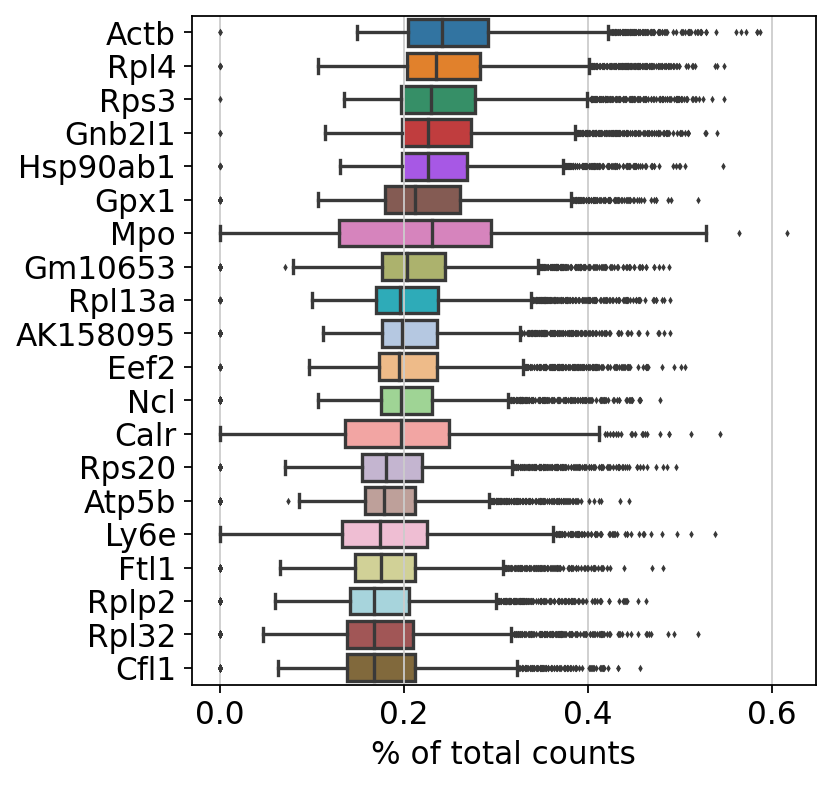

In [46]:
#filtering genes
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_counts=1) #trocar para 3-5 ou algo do genero

print(adata.n_obs, adata.n_vars)

sc.pl.highest_expr_genes(adata, n_top=20)



In [47]:
# #filtering genes
# sc.pp.filter_cells(adata, min_genes=300)
# sc.pp.filter_genes(adata, min_cells=3) #trocar para 3-5 ou algo do genero
#
# print(adata.n_obs, adata.n_vars)
#
# sc.pl.highest_expr_genes(adata, n_top=20)

### Filtering mitochondrial genes

In [48]:
#mt expression
# filter for percent mito

adata = adata[adata.obs['pct_counts_mt'] < 1.7, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 3, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 2574


## Data Correction

In [49]:
sc.pp.normalize_per_cell(adata)                 # renormalize after filtering

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Doublets

Preprocessing...
Simulating doublets...


/home/acinom/anaconda3/lib/python3.8/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/acinom/anaconda3/lib/python3.8/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 35.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.1%
Elapsed time: 1.8 seconds


1

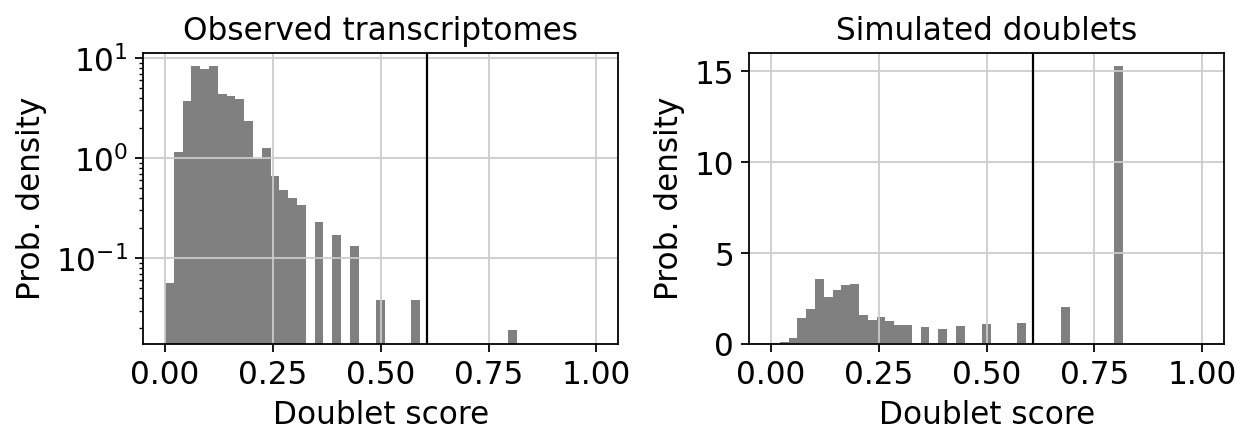

In [50]:
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

## Saving pre-processing results

In [51]:
adata.write(results_file)